In [1]:
from totalface.model_zoo.model_common import load_onnx,load_tensorRT,load_openvino
from totalface.data import read_image

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pkg_resources/_vendor/packaging/version.py:111: DeprecationWarning: Creating a LegacyVersion has been deprecated and will be removed in the next major release
  warnings.warn(


In [2]:
def normalization(rgb_img,mean_list=[0.485, 0.456, 0.406],std_list=[0.229, 0.224, 0.225]):
    MEAN = 255 * np.array(mean_list)
    STD = 255 * np.array(std_list)
    rgb_img = rgb_img.transpose(-1, 0, 1)
    norm_img = (rgb_img - MEAN[:, None, None]) / STD[:, None, None]
    
    return norm_img

In [ ]:
# model load

# onnx (norm, numpy array, (H,W,C))
lb_num=7
input_size=112
model_type='onnx'
model_path = "dan_230503_e34.onnx"
model = load_onnx.Onnx_session(model_path,input_mean=0.0, input_std=1.0,output_sort=True,onnx_device='cuda')

# # tensorRT (norm, torch tensor, (N,C,H,W)
# lb_num=5
# input_size=112
# model_type='trt'
# model_path = "dan_230503_e34.v8.trt"
# model = load_tensorRT.TrtModel(model_path,torch_image=True,not_norm=True)

# # openvino (norm, torch tensor, (N,C,H,W)
# lb_num=5
# input_size=112
# model_type='openvino'
# model_path = ["dan_230503_e34.xml", \
#               "dan_230503_e34.bin"]
# #model_path = ["dan_230503_e34_quantINT8.xml", \
# #                "dan_230503_e34_quantINT8.bin"]
# model = load_openvino.Openvino(model_path,not_norm=True,torch_image=True)

In [4]:
if lb_num==5:
    exp_cls = ['happy','surprise','anger','sorrow','neurality']
elif lb_num==7:
    exp_cls = ["happy","embarrassed","anger","anxious","hurt","sorrow","neutrality"]

In [5]:
import torch

In [11]:
img_path = "ffhq_aligned/happiness/69000_69512.png" # aligned image
img = read_image(img_path)
img = cv2.resize(img,(input_size,input_size))
norm_aimg = normalization(img)
if model_type=='onnx':
    norm_aimg = norm_aimg.transpose(1,2,0) # (3,size,size) -> (size,size,3) 
else:
    norm_aimg = torch.from_numpy(norm_aimg).unsqueeze(0)

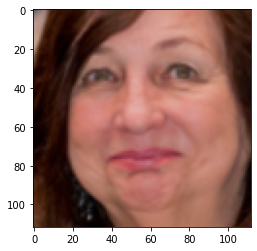

In [12]:
plt.imshow(img)

In [16]:
_,_,out = model(norm_aimg) #prob

In [18]:
out

array([[ 3.332457  ,  1.5823423 ,  2.2560663 ,  0.97793984, -2.7322433 ,
        -4.155884  , -2.5783303 ]], dtype=float32)

In [17]:
pred = np.argmax(out)
pred = exp_cls[pred]
print(pred)

happy


In [19]:
def softmax(x):
    f_x = np.exp(x) / np.sum(np.exp(x))
    return f_x

In [20]:
output_sf = softmax(out)[0]

In [21]:
output_sf

array([6.1915290e-01, 1.0758030e-01, 2.1102181e-01, 5.8781963e-02,
       1.4385734e-03, 3.4645977e-04, 1.6779368e-03], dtype=float32)